# Hands-on: Run the AIFS


This notebook describes how to run inference of the AIFS from an existing checkpoint. 


Resources:
[anemoi-inference](https://anemoi-inference.readthedocs.io/en/latest/apis/level1.html) package.

## Install Required Packages and Imports


Fastest installation with `uv`. Get `uv` by running: 
```bash
curl -LsSf https://astral.sh/uv/install.sh | sh

```
Create environment and install required packages:
```bash
uv venv --python=3.12 
source .venv/bin/activate
uv pip install anemoi-training anemoi-models anemoi-inference anemoi-datasets torch torchvision
```

We have already done that for you on the EWC, so you are good to go! 

In [2]:
import datetime
import logging
from collections import defaultdict
from helpers import find_nearest_point_index
import torch
import numpy as np
import copy

In [3]:
LOGGER = logging.getLogger(__name__) # Setup Logger for debugging

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
from anemoi.inference.checkpoint import Checkpoint
from anemoi.inference.runners.simple import SimpleRunner
from anemoi.inference.outputs.printer import print_state

## Get information from the checkpoint

The checkpoint contains ...


In [6]:
ckpt_file = "./inference-aifs-o96.ckpt"
ckpt = Checkpoint(ckpt_file)

Variables the model has been trained on:

In [7]:
len(ckpt.variable_categories())

101

In [8]:
diagnostic_vars = ckpt.diagnostic_variables
prognostic_vars = ckpt.prognostic_variables

print(f"Diagnostic variables: {diagnostic_vars}")
print(f"Prognostic variables: {prognostic_vars}")

Diagnostic variables: ['cp', 'tp']
Prognostic variables: ['10u', '10v', '2d', '2t', 'msl', 'q_100', 'q_1000', 'q_150', 'q_200', 'q_250', 'q_300', 'q_400', 'q_50', 'q_500', 'q_600', 'q_700', 'q_850', 'q_925', 'skt', 'sp', 't_100', 't_1000', 't_150', 't_200', 't_250', 't_300', 't_400', 't_50', 't_500', 't_600', 't_700', 't_850', 't_925', 'tcw', 'u_100', 'u_1000', 'u_150', 'u_200', 'u_250', 'u_300', 'u_400', 'u_50', 'u_500', 'u_600', 'u_700', 'u_850', 'u_925', 'v_100', 'v_1000', 'v_150', 'v_200', 'v_250', 'v_300', 'v_400', 'v_50', 'v_500', 'v_600', 'v_700', 'v_850', 'v_925', 'w_100', 'w_1000', 'w_150', 'w_200', 'w_250', 'w_300', 'w_400', 'w_50', 'w_500', 'w_600', 'w_700', 'w_850', 'w_925', 'z_100', 'z_1000', 'z_150', 'z_200', 'z_250', 'z_300', 'z_400', 'z_50', 'z_500', 'z_600', 'z_700', 'z_850', 'z_925']


The model architecture

In [9]:
model = torch.load(ckpt.path, weights_only=False)
model

AnemoiModelInterface(
  (pre_processors): Processors [forward](ModuleDict(
    (normalizer): InputNormalizer()
  ))
  (post_processors): Processors [inverse](ModuleDict(
    (normalizer): InputNormalizer()
  ))
  (model): AnemoiModelEncProcDec(
    (node_attributes): NamedNodesAttributes(
      (trainable_tensors): ModuleDict(
        (data): TrainableTensor()
        (hidden): TrainableTensor()
      )
    )
    (encoder): GraphTransformerForwardMapper(
      (activation): GELU(approximate='none')
      (trainable): TrainableTensor()
      (proc): GraphTransformerMapperBlock(
        (lin_key): Linear(in_features=1024, out_features=1024, bias=True)
        (lin_query): Linear(in_features=1024, out_features=1024, bias=True)
        (lin_value): Linear(in_features=1024, out_features=1024, bias=True)
        (lin_self): Linear(in_features=1024, out_features=1024, bias=True)
        (lin_edge): Linear(in_features=11, out_features=1024, bias=True)
        (conv): GraphTransformerConv()
   

In [10]:
print(f"Number of weights: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of weights: 231139096


## Get initial conditions


Running the model for inference requires initial conditions. We can


a. Retrieve Initial Conditions from ECMWF Open Data

b. Use the initial conditions from the anemoi-dataset used for training




In [11]:
# Setup Runner
runner = SimpleRunner(ckpt_file)

### a. Retrieve Initial Conditions from ECMWF Open Data


In [12]:
import datetime
from collections import defaultdict
from pathlib import Path

import numpy as np
import earthkit.data as ekd
import earthkit.regrid as ekr

from ecmwf.opendata import Client as OpendataClient
from helpers import load_saved_state, save_state

In [13]:
R = 6371.0  # Earth radius in km
GRID_RESOLUTION = "O96"
PARAM_SFC = ["10u", "10v", "2d", "2t", "msl", "skt", "sp", "tcw", "lsm", "z", "slor", "sdor"]
PARAM_SOIL = ["vsw", "sot"]
PARAM_PL = ["gh", "t", "u", "v", "w", "q"]
LEVELS = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]
SOIL_LEVELS = [1, 2]

DATE = OpendataClient().latest()
print("Initial date is", DATE)

Initial date is 2025-10-27 06:00:00


In [14]:
def get_open_data(param, levelist=[], reference_date=DATE):
    fields = defaultdict(list)
    # Get the data for the current date and the previous date
    for date in [reference_date - datetime.timedelta(hours=6), reference_date]:
        data = ekd.from_source("ecmwf-open-data", date=date, param=param, levelist=levelist)
        for f in data:
            # Open data is between -180 and 180, we need to shift it to 0-360
            assert f.to_numpy().shape == (721, 1440)
            values = np.roll(f.to_numpy(), -f.shape[1] // 2, axis=1)
            # Interpolate the data to from 0.25 to grid
            values = ekr.interpolate(values, {"grid": (0.25, 0.25)}, {"grid": GRID_RESOLUTION})
            # Add the values to the list
            name = f"{f.metadata('param')}_{f.metadata('levelist')}" if levelist else f.metadata("param")
            fields[name].append(values)

    # Create a single matrix for each parameter
    for param, values in fields.items():
        fields[param] = np.stack(values)

    return fields

Here we make a single forecast, from the control initial condition of the ensemble. In operations, this model is run 51 times, once from the control and 50 more times from slightly different initial conditions. 

To get different ensemble initial conditions from the ifs pertubation, set `number` to an ensemble number, between 1-50.


In [15]:
file = Path(f"inputstate-{DATE.strftime('%Y%m%d_%H')}.npz")
if file.exists():
    input_state = load_saved_state(file)
    LOGGER.info(f"Input state loaded from file {file}")
else:
    fields = {}
    # Surface fields
    fields.update(get_open_data(param=PARAM_SFC, reference_date=DATE))
    # Pressure levels fields
    fields.update(get_open_data(param=PARAM_PL, levelist=LEVELS, reference_date=DATE))
    # Soil parameters
    # fields.update(get_open_data(param=PARAM_SOIL,levelist=SOIL_LEVELS, reference_date=date))
    # fields = rename_keys(fields, {'sot_1': 'stl1', 'sot_2': 'stl2', 'vsw_1': 'swvl1', 'vsw_2': 'swvl2'})

    # Convert geopotential height into geopotential
    for level in LEVELS:
        gh = fields.pop(f"gh_{level}")
        fields[f"z_{level}"] = gh * 9.80665
    
    input_state = dict(date=DATE, fields=fields)

    LOGGER.info(f"State created for date {DATE}")
    save_state(input_state, file)

    LOGGER.info(f"State saved to file {file}")

<multiple>:   0%|          | 0.00/7.42M [00:00<?, ?B/s]

<multiple>:   0%|          | 0.00/7.43M [00:00<?, ?B/s]

<multiple>:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

<multiple>:   0%|          | 0.00/53.6M [00:00<?, ?B/s]

## Run inference from initial conditions

In [16]:
runner = SimpleRunner(ckpt_file, device="cuda")

In [17]:
LEAD_TIME = 48

### Run the forecast



In [18]:
ens_members = 4
forecast_states = [[] for nn in range(ens_members)]
for nn in range(ens_members):
    for step, state in enumerate(runner.run(input_state=input_state, lead_time=LEAD_TIME)):
        LOGGER.info(f"Step {step}: {state['date']} (lead time: {state['step']})")
        LOGGER.info(f"  Available fields: {list(state['fields'].keys())}")
        # Store the state if you want to keep it
        forecast_states[nn].append(copy.deepcopy(state))

LOGGER.info(f"Forecast completed! Generated {len(forecast_states)} time steps.")

In [19]:
print(f"Predicted dates: {list(forecast_states[0][x]['date'].strftime('%Y-%m-%dT%H') for x in range(len(forecast_states)))}")

Predicted dates: ['2025-10-27T12', '2025-10-27T18', '2025-10-28T00', '2025-10-28T06']


# 4. Inspect the generated forecast

### Plot a field

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.tri as tri

In [28]:
def fix(lons):
    # Shift the longitudes from 0-360 to -180-180
    return np.where(lons > 180, lons - 360, lons)

# pick a state of the first ensemble members
state = forecast_states[0][-1]
date = state['date']
latitudes = state["latitudes"]
longitudes = fix(state["longitudes"])
values = state["fields"]["10u"]

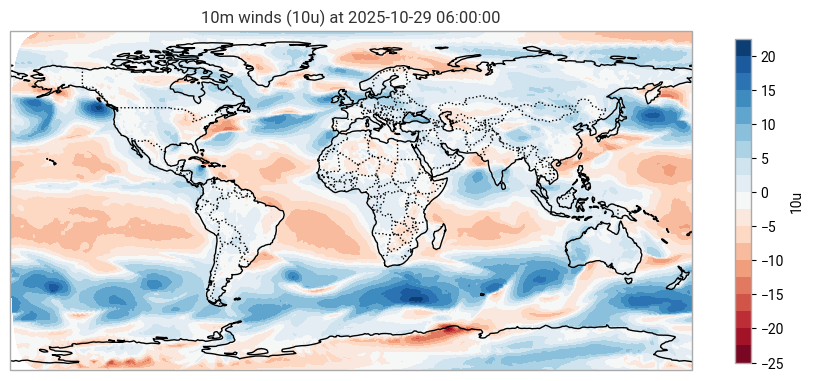

In [31]:
fig, ax = plt.subplots(figsize=(11, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

triangulation = tri.Triangulation(fix(longitudes), latitudes)

contour=ax.tricontourf(triangulation, values, levels=20, transform=ccrs.PlateCarree(), cmap="RdBu")
cbar = fig.colorbar(contour, ax=ax, orientation="vertical", shrink=0.7, label="10u")

plt.title("10m winds (10u) at {}".format(state["date"]))
plt.show()


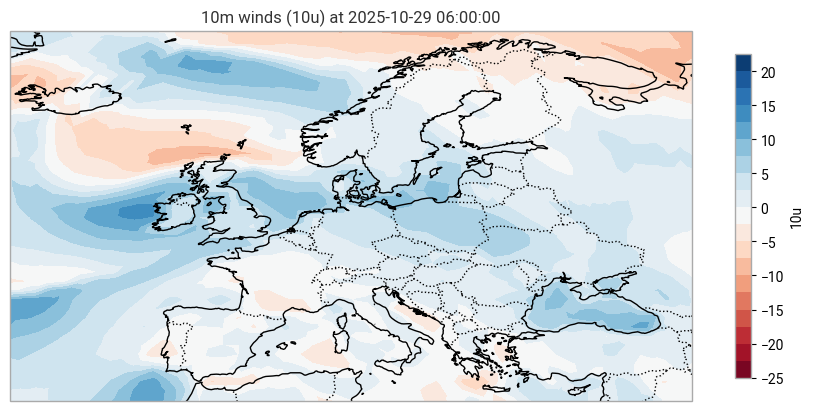

In [32]:
fig, ax = plt.subplots(figsize=(11, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Limit the map to Europe
ax.set_extent([-25, 45, 34, 72], crs=ccrs.PlateCarree())

triangulation = tri.Triangulation(fix(longitudes), latitudes)

contour=ax.tricontourf(triangulation, values, levels=20, transform=ccrs.PlateCarree(), cmap="RdBu")
cbar = fig.colorbar(contour, ax=ax, orientation="vertical", shrink=0.7, label="10u")

plt.title("10m winds (10u) at {}".format(state["date"]))
plt.show()

### Task 4.1: Plot the 2m temperature forecasts for the weekend?

The forecast is already calculated. Just make sure to select the correct state from the list and select the wanted parameter. The legend must be edited manually. Feel free to convert from Kelvin to Celcius.

Extra task: How much does the 10-day forecast over Europe differ for the different ensemble members?

### Plot a forecast plume

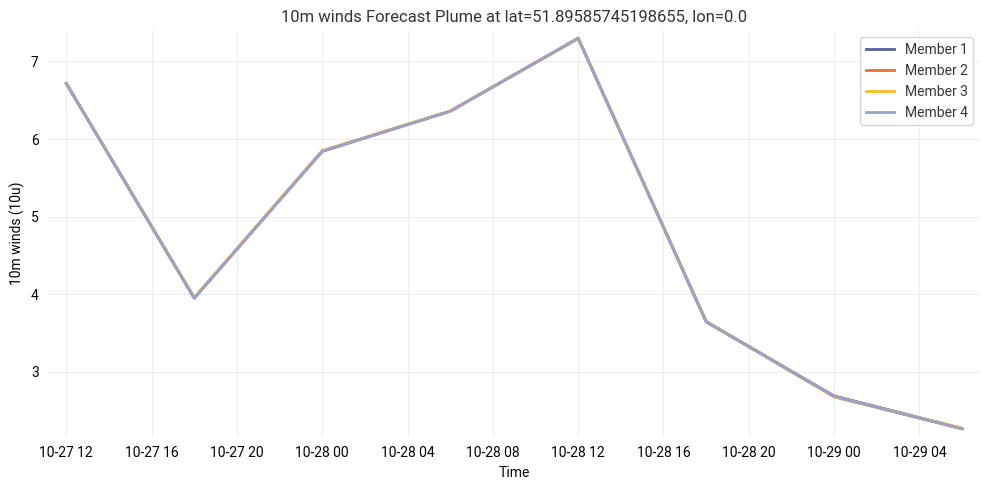

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

lat_target = 51.45
lon_target = -0.98
idx_nearest = find_nearest_point_index(latitudes, longitudes, lat_target, lon_target)

lead_times = range(len(forecast_states[0]))
n_members = 4  # we know there are 4 ensemble members

# Extract field for all members and times
values = np.array([
    [forecast_states[m][t]["fields"]["10u"][idx_nearest] for t in lead_times]
    for m in range(n_members)
])

# Time axis
times = [forecast_states[0][t]["date"] for t in lead_times]
times = pd.to_datetime(times)

# Plot
plt.figure(figsize=(10, 5))

for m in range(n_members):
    plt.plot(times, values[m, :], linewidth=2, label=f"Member {m+1}")

plt.title(f"10m winds Forecast Plume at lat={latitudes[idx_nearest]}, lon={longitudes[idx_nearest]}")
plt.xlabel("Time")
plt.ylabel("10m winds (10u)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Task 4.2: Plot a 2m temperature forecast plume for the location of your city?

We have provided an example for the Reading, UK. Change to the location of the city you live in and and select the wanted parameter. 

Extra task: Try to calculate the forecast for more than 48 hours to have an idea of how warm it is going to be next week.

### Task 5: Explore out of sample data in the initial conditions

We have provided a way to get data whoch matches what the model was trained for, explore what happens if the data is incorrect 